In [1]:
from sklearn.datasets import load_diabetes
from sklearn.utils import shuffle
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def is_GPU(tensor):
    '''
    函数名 : cpu 或者 gpu 自动推断函数
    :param tensor: tensor结构数据
    :return: 根据系统转cpu或者gpu结构
    '''
    if torch.cuda.is_available():
        return tensor.cuda()
    return tensor

def yhat_function(X,theta,b): # 期望函数
    '''
    函数名 : yhot函数 / 模型的期望的y值的函数
    :param X: 数据集
    :param a: 待迭代参数
    :param b: 偏置选项
    :return: 模型的线性期望
    '''
    return is_GPU(X.mm(theta)+b)

def initialize_theta(dims,b=None): # 初始化参数
    '''
    函数名 : 初始化参数函数
    :param dims: 数据集的列数
    :return: thate -> 初始化的参数 ， b -> 初始化偏置
    '''
    
    theta = is_GPU(torch.zeros((dims, 1)))
    if b == None :
        b = 0
    return theta, b


def loss_function(y_hat,y,m): # 损失函数
    '''
    函数名 : 损失函数
    :param y_hat: 模型当前拟合的y值
    :param y: 真实的y值
    :param m: 数据集的行数
    :return: 损失值
    '''
    return is_GPU(((y_hat-y)**2).sum()/m)

def partial_derivative_function(X,yhat,Y,m): # 求偏导数
    '''
    函数名 : 求偏导数函数
    :param X: 数据集
    :param yhat: y值的拟合过程
    :param Y: 真实的y值
    :param m: 数据集X的行数
    :return: 偏导数
    '''
    dw = X.T.mm(yhat-Y)/m
    db = (yhat-Y).sum()/m
    return dw,db

def liner_model(X_train,y_train,b=None
                ,maxloop = 10000
                ,alpha = 0.001
                ,convergence_threshold = 10**(-8)
                ,display=False,display_cycle=False):
    '''
    :param X_train: 训练集X
    :param y_train: 训练标签 y
    :param b:偏置项
    :param maxloop: 最大迭代次数
    :param alpha: 学习率
    :param convergence_threshold: 收敛阈值
    :param display:是否显示迭代过程与损失函数图像
    :param display_cycle: 显示迭代过程的间隔，默认每1/10次显示
    :return: lossdata -> 损失函数过程收集,loss ->最终损失值 , params —> 参数 , grads -> 梯度值 ,gradsdata -> 梯度迭代函数
    '''

    theta,b = initialize_theta(X_train.shape[1],b)
    lossdata = [np.Inf]
    m,n = X_train.shape
    gradsdata=[]
    for i in range(1,maxloop):
        yhat = yhat_function(X_train,theta,b)
        loss = loss_function(yhat,y_train,m)
        dw,db = partial_derivative_function(X_train,yhat,y_train,m)
        # 参数更新过程
        theta += is_GPU(-alpha * dw)
        b += is_GPU(-alpha * db)
        # 保存参数
        params = {'theta': theta,'b': b}
        # 保存梯度
        grads = {'dw': dw,'db': db}
        
        gradsdata.append([dw,db])
        lossdata.append(loss)
        if display:
            cycle = display_cycle == False and maxloop/10 or display
            if i % cycle == 0:
                print('epoch %d loss %f' % (i, loss))
        if lossdata[-2]-lossdata[-1] <= convergence_threshold:
            break
    if display:
        plt.plot(lossdata)
        plt.show()
        plt.close()
    print(i)
    return lossdata,loss, params, grads,gradsdata

def predict(X, params):
    '''
    :param X:
    :param params:
    :return:
    '''
    w = params['theta']
    b = params['b']
    y_pred = X.mm(w) + b
    return y_pred



diabetes = load_diabetes()
data = diabetes.data
target = diabetes.target 

# 打乱数据
X, y = shuffle(data, target, random_state=13)
X,y = is_GPU(torch.FloatTensor(X)),is_GPU(torch.FloatTensor(y))
#X = X.astype(np.float32)

# 训练集与测试集的简单划分
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

print('X_train=', X_train.shape)
print('X_test=', X_test.shape)
print('y_train=', y_train.shape)
print('y_test=', y_test.shape)


X_train= torch.Size([397, 10])
X_test= torch.Size([45, 10])
y_train= torch.Size([397, 1])
y_test= torch.Size([45, 1])


epoch 1000 loss 8983.930664
epoch 2000 loss 6247.530762
epoch 3000 loss 5844.119141
epoch 4000 loss 5756.683105
epoch 5000 loss 5712.511230
epoch 6000 loss 5674.725586
epoch 7000 loss 5638.329102
epoch 8000 loss 5602.636719
epoch 9000 loss 5567.548340


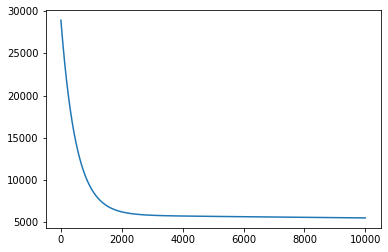

9999


In [2]:

#X = is_GPU(torch.randn(1000000,1000))*100
#Y = is_GPU(torch.randn(1000000,1))*10
lossdata,loss, params, grads,gradsdata = is_GPU(liner_model(X_train,y_train,display=True))

In [3]:
grads

{'dw': tensor([[-0.6703],
         [-0.0956],
         [-1.9716],
         [-1.5305],
         [-0.6723],
         [-0.5478],
         [ 1.3997],
         [-1.5001],
         [-1.9357],
         [-1.3095]]),
 'db': tensor(-0.0068)}

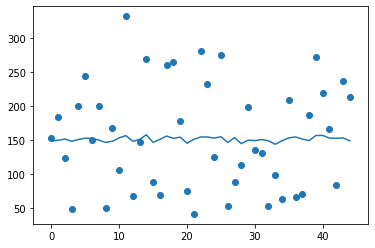

In [4]:
y_pred = predict(X_test, params)
plt.plot(y_pred)
plt.scatter(torch.arange(0,X_test.shape[0]),y_test)

In [5]:
X_test[:,0]

tensor([ 0.0018, -0.0636, -0.0091,  0.0018, -0.1072,  0.0163, -0.0237, -0.0491,
        -0.0055, -0.0745, -0.0382,  0.0599, -0.0854, -0.0237,  0.0308,  0.0671,
         0.0272,  0.0744,  0.0090, -0.0309, -0.0019, -0.0091,  0.0235, -0.0782,
        -0.0491, -0.0200, -0.0091,  0.0780,  0.0018,  0.0817, -0.0128,  0.0417,
        -0.0273, -0.0891, -0.0128, -0.0091,  0.0272,  0.0417, -0.0600, -0.0237,
        -0.0382, -0.0055,  0.0126,  0.0453, -0.0636])

In [6]:
import os
os.getcwd()

'/Users/manmanzhang/Library/Mobile Documents/com~apple~CloudDocs/MyProject/InferenceSystem/src/I5_algorithm/torch深度学习实验室'